This is a starter notebook for the [Kitchenware classification](https://www.kaggle.com/competitions/kitchenware-classification) competition on Kaggle

To get started:

- Join the competition and accept rules
- Download your Kaggle credentials file
- If you're running in Saturn Cloud, configure your instance to have access to access the kaggle credentials

When this is done, we can download the data. We need to execute the following cell only once

In [1]:
!kaggle competitions download -c kitchenware-classification
!mkdir data
!unzip kitchenware-classification.zip -d data > /dev/null
!rm kitchenware-classification.zip

100%|██████████████████████████████████████▊| 1.62G/1.63G [00:12<00:00, 149MB/s]
100%|███████████████████████████████████████| 1.63G/1.63G [00:12<00:00, 137MB/s]
mkdir: cannot create directory ‘data’: File exists
replace data/images/0000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [2]:
!ls

data		     keras-starter-v2.ipynb	      README.md
keras-starter.ipynb  kitchenware-jupyter-recipe.json  submission.csv


Now let's train a baseline model

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras

2022-12-21 12:00:47.020567: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'matplotlib'

In [3]:
tf.__version__

'2.10.0'

First, we will load the training dataframe and split it into train and validation

In [4]:
df_train_full = pd.read_csv('data/train.csv', dtype={'Id': str})
df_train_full['filename'] = 'data/images/' + df_train_full['Id'] + '.jpg'
df_train_full.head()

,Id,label,filename
0,0560,glass,data/images/0560.jpg
1,4675,cup,data/images/4675.jpg
2,0875,glass,data/images/0875.jpg
3,4436,spoon,data/images/4436.jpg
4,8265,plate,data/images/8265.jpg


In [6]:
df_train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5559 entries, 0 to 5558
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        5559 non-null   object
 1   label     5559 non-null   object
 2   filename  5559 non-null   object
dtypes: object(3)
memory usage: 130.4+ KB


In [5]:
#splitting train_full in train(0.8) and val(0.2)
val_cutoff = int(len(df_train_full) * 0.8)
df_train = df_train_full[:val_cutoff]
df_val = df_train_full[val_cutoff:]

Now let's create image generators

In [6]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_dataframe(
    df_val,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
)

Found 4447 validated image filenames belonging to 6 classes.
Found 1112 validated image filenames belonging to 6 classes.


In [7]:
def make_model(learning_rate):
    base_model = Xception(
        weights='imagenet',
        input_shape=(150, 150, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))

    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(6)(vector)

    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    
    return model

#### starter parameters were lr = 0.01 and epochs = 2 ####

In [12]:
model = make_model(learning_rate = 0.001)
history_0_001 = model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
139/139 [==============================] - 67s 465ms/step - loss: 0.5087 - accuracy: 0.8197 - val_loss: 0.3382 - val_accuracy: 0.8732
Epoch 2/10
139/139 [==============================] - 63s 457ms/step - loss: 0.2784 - accuracy: 0.9062 - val_loss: 0.3107 - val_accuracy: 0.8903
Epoch 3/10
139/139 [==============================] - 64s 460ms/step - loss: 0.2271 - accuracy: 0.9231 - val_loss: 0.2990 - val_accuracy: 0.8903
Epoch 4/10
139/139 [==============================] - 64s 460ms/step - loss: 0.1955 - accuracy: 0.9323 - val_loss: 0.3060 - val_accuracy: 0.8912
Epoch 5/10
139/139 [==============================] - 64s 460ms/step - loss: 0.1646 - accuracy: 0.9460 - val_loss: 0.3037 - val_accuracy: 0.8876
Epoch 6/10
139/139 [==============================] - 64s 462ms/step - loss: 0.1456 - accuracy: 0.9544 - val_loss: 0.2985 - val_accuracy: 0.9002
Epoch 7/10
139/139 [==============================] - 64s 458ms/step - loss: 0.1277 - accuracy: 0.9613 - val_loss: 0.2972 - val_ac

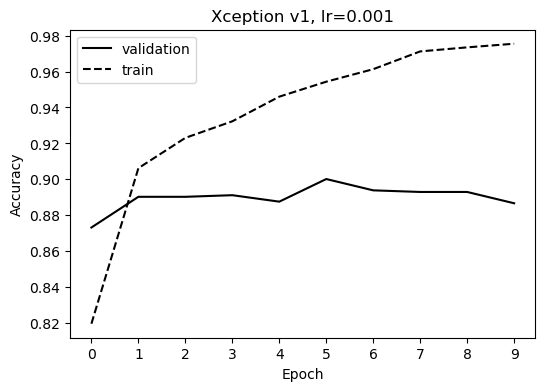

In [14]:
plt.figure(figsize=(6, 4))

epochs = history_0_001.epoch
val = history_0_001.history['val_accuracy']
train = history_0_001.history['accuracy']

plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

plt.title('Xception v1, lr=0.001')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()


plt.savefig('xception_v1_0_001.svg')

plt.show()

In [94]:
#Let's add one more layer - and a dropout between them

def make_model(learning_rate, droprate):
    base_model = Xception(
        weights='imagenet',
        input_shape=(150, 150, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))
    
    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(100, activation='relu')(vector)
    drop = keras.layers.Dropout(droprate)(inner)

    outputs = keras.layers.Dense(6)(drop)

    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    
    return model

In [37]:
model = make_model(learning_rate=0.001, droprate=0.5)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v2_0_5_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_2 = model.fit(train_generator, epochs=15, validation_data=val_generator, callbacks=callbacks)

Epoch 1/15
139/139 [==============================] - 69s 479ms/step - loss: 0.5819 - accuracy: 0.7958 - val_loss: 0.3493 - val_accuracy: 0.8768
Epoch 2/15
139/139 [==============================] - 64s 457ms/step - loss: 0.3558 - accuracy: 0.8716 - val_loss: 0.2954 - val_accuracy: 0.8939
Epoch 3/15
139/139 [==============================] - 65s 468ms/step - loss: 0.2860 - accuracy: 0.8963 - val_loss: 0.2924 - val_accuracy: 0.8966
Epoch 4/15
139/139 [==============================] - 64s 458ms/step - loss: 0.2403 - accuracy: 0.9123 - val_loss: 0.2847 - val_accuracy: 0.8957
Epoch 5/15
139/139 [==============================] - 64s 463ms/step - loss: 0.2282 - accuracy: 0.9163 - val_loss: 0.2906 - val_accuracy: 0.8876
Epoch 6/15
139/139 [==============================] - 64s 464ms/step - loss: 0.1771 - accuracy: 0.9384 - val_loss: 0.2846 - val_accuracy: 0.8966
Epoch 7/15
139/139 [==============================] - 64s 460ms/step - loss: 0.1688 - accuracy: 0.9427 - val_loss: 0.2883 - val_ac

In [38]:
epochs = history_2.epoch

train05 = history_2.history['accuracy']

val05 = history_2.history['val_accuracy']

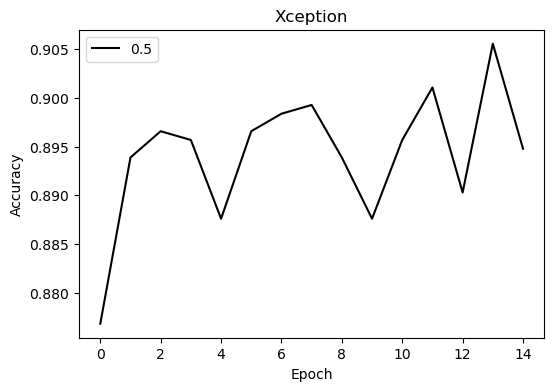

In [39]:
plt.figure(figsize=(6, 4))


plt.plot(epochs, val05, color='black', linestyle='solid', label='0.5')



plt.title('Xception')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.legend()

#plt.savefig('xception_v2_dropout.svg')

plt.show()

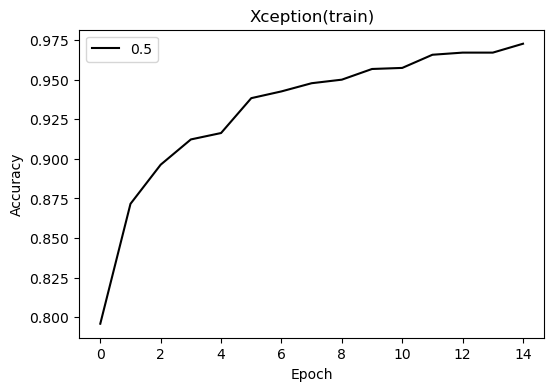

In [40]:
plt.figure(figsize=(6, 4))


plt.plot(epochs, train05, color='black', linestyle='solid', label='0.5')



plt.title('Xception(train)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.legend()

#plt.savefig('xception_v2_dropout_train.svg')

plt.show()

### DATA AUGMENTATION ###

In [97]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    zoom_range=0.1,
    horizontal_flip=True,
    #vertical_flip=True,
    rotation_range=5.0,
    fill_mode='nearest',
    #width_shift_range=0.1,
    #height_shift_range=0.1
    #channel_shift_range=0.2
    shear_range=0.2
)

train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_dataframe(
    df_val,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
)

Found 4447 validated image filenames belonging to 6 classes.
Found 1112 validated image filenames belonging to 6 classes.


In [98]:
model = make_model(learning_rate=0.001, droprate=0.5)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v3_0_5_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_3 = model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=callbacks)

Epoch 1/10
139/139 [==============================] - 83s 581ms/step - loss: 0.5925 - accuracy: 0.7882 - val_loss: 0.3029 - val_accuracy: 0.8903
Epoch 2/10
139/139 [==============================] - 80s 573ms/step - loss: 0.3814 - accuracy: 0.8631 - val_loss: 0.2855 - val_accuracy: 0.8921
Epoch 3/10
139/139 [==============================] - 80s 573ms/step - loss: 0.3360 - accuracy: 0.8813 - val_loss: 0.2727 - val_accuracy: 0.8993
Epoch 4/10
139/139 [==============================] - 79s 568ms/step - loss: 0.3066 - accuracy: 0.8916 - val_loss: 0.2964 - val_accuracy: 0.8939
Epoch 5/10
139/139 [==============================] - 79s 571ms/step - loss: 0.2796 - accuracy: 0.8984 - val_loss: 0.2998 - val_accuracy: 0.8993
Epoch 6/10
139/139 [==============================] - 80s 574ms/step - loss: 0.2608 - accuracy: 0.9031 - val_loss: 0.2974 - val_accuracy: 0.9011
Epoch 7/10
139/139 [==============================] - 79s 568ms/step - loss: 0.2531 - accuracy: 0.9042 - val_loss: 0.2958 - val_ac

In [99]:
epochs = history_3.epoch

train05 = history_3.history['accuracy']

val05 = history_3.history['val_accuracy']

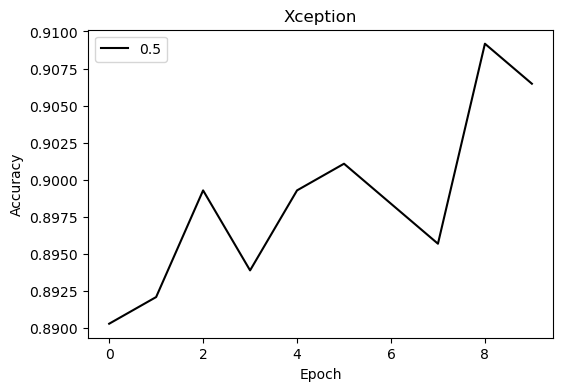

In [100]:
plt.figure(figsize=(6, 4))


plt.plot(epochs, val05, color='black', linestyle='solid', label='0.5')



plt.title('Xception')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.legend()

#plt.savefig('xception_v2_dropout.svg')

plt.show()

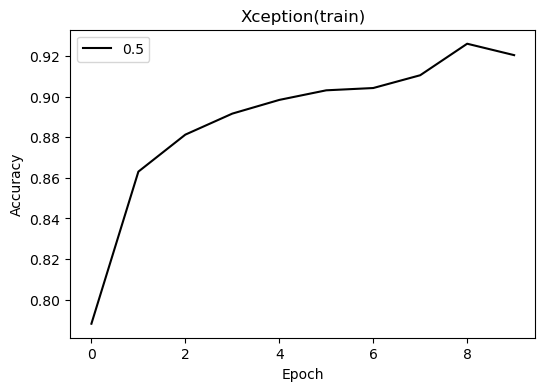

In [101]:
plt.figure(figsize=(6, 4))


plt.plot(epochs, train05, color='black', linestyle='solid', label='0.5')



plt.title('Xception(train)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.legend()

#plt.savefig('xception_v2_dropout_train.svg')

plt.show()

### FINE TUNING ###

In [117]:
base_model = Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False
)

base_model.trainable = False

inputs = keras.Input(shape=(150, 150, 3))
    
base = base_model(inputs, training=False)
vector = keras.layers.GlobalAveragePooling2D()(base)

inner = keras.layers.Dense(100, activation='relu')(vector)
drop = keras.layers.Dropout(rate=0.5)(inner)

outputs = keras.layers.Dense(6)(drop)

model = keras.Model(inputs, outputs)
    
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
    

In [118]:
model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
139/139 [==============================] - 82s 578ms/step - loss: 0.6039 - accuracy: 0.7884 - val_loss: 0.3232 - val_accuracy: 0.8804
Epoch 2/10
139/139 [==============================] - 79s 570ms/step - loss: 0.3898 - accuracy: 0.8604 - val_loss: 0.2991 - val_accuracy: 0.8903
Epoch 3/10
139/139 [==============================] - 79s 570ms/step - loss: 0.3411 - accuracy: 0.8781 - val_loss: 0.3146 - val_accuracy: 0.8912
Epoch 4/10
139/139 [==============================] - 80s 572ms/step - loss: 0.3098 - accuracy: 0.8876 - val_loss: 0.3116 - val_accuracy: 0.8939
Epoch 5/10
139/139 [==============================] - 79s 571ms/step - loss: 0.2789 - accuracy: 0.8981 - val_loss: 0.2949 - val_accuracy: 0.8894
Epoch 6/10
139/139 [==============================] - 79s 567ms/step - loss: 0.2662 - accuracy: 0.9026 - val_loss: 0.2950 - val_accuracy: 0.8939
Epoch 7/10
139/139 [==============================] - 79s 570ms/step - loss: 0.2484 - accuracy: 0.9098 - val_loss: 0.3008 - val_ac

In [119]:
#unfreeze the last 32 layers of the base model for doing a partial fine tuning 
base_model.trainable = True
for layer in base_model.layers[:-32]:
  layer.trainable = False

'''
    inputs = keras.Input(shape=(150, 150, 3))

    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(100, activation='relu')(vector)
    drop = keras.layers.Dropout(rate=0.5)(inner)

    outputs = keras.layers.Dense(6)(drop)

    model = keras.Model(inputs, outputs)
'''

"\n    inputs = keras.Input(shape=(150, 150, 3))\n\n    base = base_model(inputs, training=False)\n    vector = keras.layers.GlobalAveragePooling2D()(base)\n\n    inner = keras.layers.Dense(100, activation='relu')(vector)\n    drop = keras.layers.Dropout(rate=0.5)(inner)\n\n    outputs = keras.layers.Dense(6)(drop)\n\n    model = keras.Model(inputs, outputs)\n"

In [120]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),  # Low learning rate to avoid desstruction of the learned weights
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v4_0_5_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=callbacks)

Epoch 1/10
139/139 [==============================] - 84s 581ms/step - loss: 0.1718 - accuracy: 0.9377 - val_loss: 0.2863 - val_accuracy: 0.9029
Epoch 2/10
139/139 [==============================] - 80s 575ms/step - loss: 0.1461 - accuracy: 0.9494 - val_loss: 0.2744 - val_accuracy: 0.9128
Epoch 3/10
139/139 [==============================] - 80s 574ms/step - loss: 0.1229 - accuracy: 0.9505 - val_loss: 0.2783 - val_accuracy: 0.9128
Epoch 4/10
139/139 [==============================] - 80s 575ms/step - loss: 0.1086 - accuracy: 0.9597 - val_loss: 0.2773 - val_accuracy: 0.9155
Epoch 5/10
139/139 [==============================] - 80s 573ms/step - loss: 0.0956 - accuracy: 0.9658 - val_loss: 0.2839 - val_accuracy: 0.9173
Epoch 6/10
139/139 [==============================] - 79s 569ms/step - loss: 0.0813 - accuracy: 0.9699 - val_loss: 0.3116 - val_accuracy: 0.9146
Epoch 7/10
139/139 [==============================] - 79s 572ms/step - loss: 0.0799 - accuracy: 0.9696 - val_loss: 0.2960 - val_ac

Now let's use this model to predict the labels for test data

In [121]:
#model = keras.models.load_model('xception_v2_0_5_14_0.906.h5') #best result case with 1 more layer and dropout

#model = keras.models.load_model('xception_v3_0_5_15_0.902.h5') #1 more layer, dropout and augmentation
#model = keras.models.load_model('xception_v3_0_5_09_0.909.h5') #1 more layer, dropout and augmentation final

model = keras.models.load_model('xception_v4_0_5_10_0.922.h5') #1 more layer, dropout, augmentation and partial fine tuning


In [122]:
df_test = pd.read_csv('data/test.csv', dtype={'Id': str})
df_test['filename'] = 'data/images/' + df_test['Id'] + '.jpg'
df_test.head()

,Id,filename
0,0678,data/images/0678.jpg
1,3962,data/images/3962.jpg
2,9271,data/images/9271.jpg
3,5133,data/images/5133.jpg
4,8842,data/images/8842.jpg


In [123]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

#class_mode = 'input'means that in the label arrays that are returned each label will be will be images identical to input images
#useful for fitting autoencoders

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='filename',
    class_mode='input',
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)

Found 3808 validated image filenames.


In [124]:
test_generator.filenames[:5]

['data/images/0678.jpg',
 'data/images/3962.jpg',
 'data/images/9271.jpg',
 'data/images/5133.jpg',
 'data/images/8842.jpg']

In [125]:
y_pred = model.predict(test_generator)

119/119 [==============================] - 43s 355ms/step


In [126]:
#dtype = '<U5' means unicode 5 characters with byte-order little-endian (<)
classes = np.array(list(train_generator.class_indices.keys()))
classes

array(['cup', 'fork', 'glass', 'knife', 'plate', 'spoon'], dtype='<U5')

In [127]:
predictions = classes[y_pred.argmax(axis=1)]

In [128]:
predictions[:5]

array(['knife', 'knife', 'fork', 'plate', 'fork'], dtype='<U5')

## Finally, we need to prepare the submission ##

### submitted till now: 
1) lr=0.01 epochs=2 val_acc=0.8085 (scored on kaggle as 0.81860) \
2) lr=0.01 epochs=5 val_acc=0.8741 (scored as 0.88062) \
3) lr=0.01 epochs=10 val_accuracy=0.8822  (scored as? NOT submitted, overfitting  ) \
4) lr=0.1 epochs=10 val_accuracy=0.8831   (scored as ? NOT submitted, overfitting ) \
5) lr=0.001 epochs=10 val_accuracy=0.8867   (scored as ? NOT submitted, overfitting ) \
6) lr=0.001 epochs=15 val_accuracy=0.8948  (scored as ? NOT submitted, overfitting ) \
7) lr=0.001 epochs=15 val_accuracy=0.9006  (scored as 0.89302 ) \
8) lr=0.001 epochs=15, data_augmentation, val_accuracy=0.9020  (scored as 0.89819 ) \
9) lr=0.001 epochs=15, data_augmentation, val_accuracy=0.9065  (scored as 0.89819 ) \
10) lr=0.001 epochs=10, data_augmentation, partial fine tuning val_accuracy=0.9218  (scored as 0.92144) \


In [129]:
df_submission = pd.DataFrame()
df_submission['filename'] = test_generator.filenames
df_submission['label'] = predictions

df_submission['Id'] = df_submission.filename.str[len('data/images/'):-4]
del df_submission['filename']

In [130]:
df_submission.head()

,label,Id
0,knife,0678
1,knife,3962
2,fork,9271
3,plate,5133
4,fork,8842


In [131]:
df_submission[['Id', 'label']].to_csv('submission.csv', index=False)

In [133]:
#val_acc = round(history_3.history['val_accuracy'][-1], 4)
val_acc = 0.9218
print(f'validation: {val_acc}')

validation: 0.9218


In [134]:
!kaggle competitions submit kitchenware-classification -f submission.csv -m f'validation: {val_acc}'

100%|██████████████████████████████████████| 38.9k/38.9k [00:00<00:00, 54.5kB/s]
Successfully submitted to Kitchenware Classification